# Theoretical numerical analysis of convolutional LDPC codes

In [1]:
import os
import sys
import csv
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# parseStr = lambda x: x.isalpha() and x or x.isdigit() and int(x) or x.isalnum() and\
# x or len(set(string.punctuation).intersection(x)) == 1 and x.count('.') == 1 and float(x) or x

## 1. Parameters of recurrence and plotting

In [2]:
d = 3
G = 2 # (3,6) LDPC code
eta = 0.5
L = 61 # number of copies
ITER_TIMES = 50000*L
deltas = np.arange(0,1.0001,0.0001)#np.arange(0,1.001,0.001)
deltas_tick = np.arange(0,1.1,0.1)
#q_str = ['{:.1f}'.format(q) for q in q_range] # q會跑哪些值

In [4]:
# d = int(sys.argv[1])
# G = int(sys.argv[2])
# eta = float(sys.argv[3])
# L = int(sys.argv[4])
# ITER_TIMES = 50000*L

In [3]:
plot_dir = "./theoretical/"
regular_dir = "./theoretical/regular/" + str(eta) + '/'
irregular_dir = "./theoretical/irregular/" + str(eta) + '/'
sho_dir = "./theoretical/shokrollahi/" + str(eta) + '/'
rich_dir = "./theoretical/richardson/" + str(eta) + '/'
if not os.path.exists(regular_dir) : os.makedirs(regular_dir)
if not os.path.exists(irregular_dir) : os.makedirs(irregular_dir)
if not os.path.exists(sho_dir) : os.makedirs(sho_dir)
if not os.path.exists(rich_dir) : os.makedirs(rich_dir)

## 2. Generating functions of degree distribution

### (1) Regular LDPC

In [6]:
def rho(z):
    return np.power(z,G*d-1)
    
def lambda_(z):
    return np.power(z,d-1)

### (2) Irregular convoluted (example 1)
$$q_k=\frac{(k+1)}{E[k]}p_{k+1}$$
$$\rho(z)=\frac{1}{2}z^{d-1} + \frac{1}{2}z^{2d-1}$$
$$\lambda(z)=\frac{1}{2}z^{Gd-1} + \frac{1}{2}z^{2Gd-1}$$

In [7]:
def rho_irr(z):
    return (1/2)*np.power(z,G*d-1) + (1/2)*np.power(z,2*G*d-1)
    
def lambda_irr(z):
    return (1/2)*np.power(z,d-1) + (1/2)*np.power(z,2*d-1)

### (3) Shokrollahi's generating function
A. Shokrollahi and R. Storn, “Design of efficient erasure codes with differential evolution,” in 2020 IEEE International Symposium on Information Theory (ISIT), 2000.
$$\lambda(z) = 0.26328z+0.18020z^2 +0.27000z^6 +0.28649z^{29}$$
$$\rho(z) = 0.63407z^7 + 0.36593z^8$$

In [4]:
def rho_sho(z):
    return 0.63407*np.power(z,7)+0.36593*np.power(z,8)
    
def lambda_sho(z):
    return 0.26328*z+0.18020*np.power(z,2)+0.27000*np.power(z,6)+0.28649*np.power(z,29)

### (4) Richardson's generating function
T. Richardson and R. Urbanke, Modern coding theory. Cambridge university press, 2008.
$$\lambda(z) = 0.106257z+0.486659z^2 +0.010390z^{10} +0.396694z^{19}$$
$$\rho(z) = 0.5z^7 + 0.5z^8$$

In [9]:
def rho_rich(z):
    return 0.5*np.power(z,7) + 0.5*np.power(z,8)
    
def lambda_rich(z):
    return 0.106257*z+0.486659*np.power(z,2)+0.010390*np.power(z,10)+0.396694*np.power(z,19)

## 3. Recurence relations 
### (1) Regular LDPC code
實驗組：convoluted

In [10]:
alpha_lines = [] # 共1000個點
beta_lines = [] # 共1000個點
iter_L = []

In [11]:
for delta in tqdm(deltas): # 共1000個點
    alpha_d_i = [[delta] * (L-1)] # 每一點initial condition
    beta_d_i = [[0] * L] # beta的initial condition沒差
    for i in range(1,ITER_TIMES): # 每一點迭代1000次
        beta_d_i_c = []
        for c in range(0, L): # beta共L條線, paper上的下標1代表此處的index c=0
            if (c==0):
                b = 1 - rho(1 - (1 - eta) * alpha_d_i[i-1][0])
            elif (c==L-1):
                b = 1 - rho(1 - eta * alpha_d_i[i-1][L-2])
            else:
                b = 1 - rho(1 - (1-eta) * alpha_d_i[i-1][c] - eta * alpha_d_i[i-1][c-1])
            beta_d_i_c.append(b)
            
        beta_d_i.append(beta_d_i_c)
        
        alpha_d_i_v = []
        for v in range(0, L-1): # alpha共L-1條線, paper上的下標1代表此處的index v=0
            a = delta * lambda_((1-eta) * beta_d_i[i][v] + eta * beta_d_i[i][v+1])
            alpha_d_i_v.append(a)
            
        diff_a = []
        for x,y in zip(alpha_d_i[-1], alpha_d_i_v):
            diff_a.append(abs(x-y))
        if (all(d <= 1e-8 for d in diff_a)):
            break
    
        alpha_d_i.append(alpha_d_i_v)
    iter_L.append(i)
    alpha_lines.append(alpha_d_i[-1])
    beta_lines.append(beta_d_i[-1])

100%|██████████████████████████████████| 10001/10001 [00:00<00:00, 10589.82it/s]


In [12]:
alpha_lines = np.array(alpha_lines).transpose()
beta_lines = np.array(beta_lines).transpose()

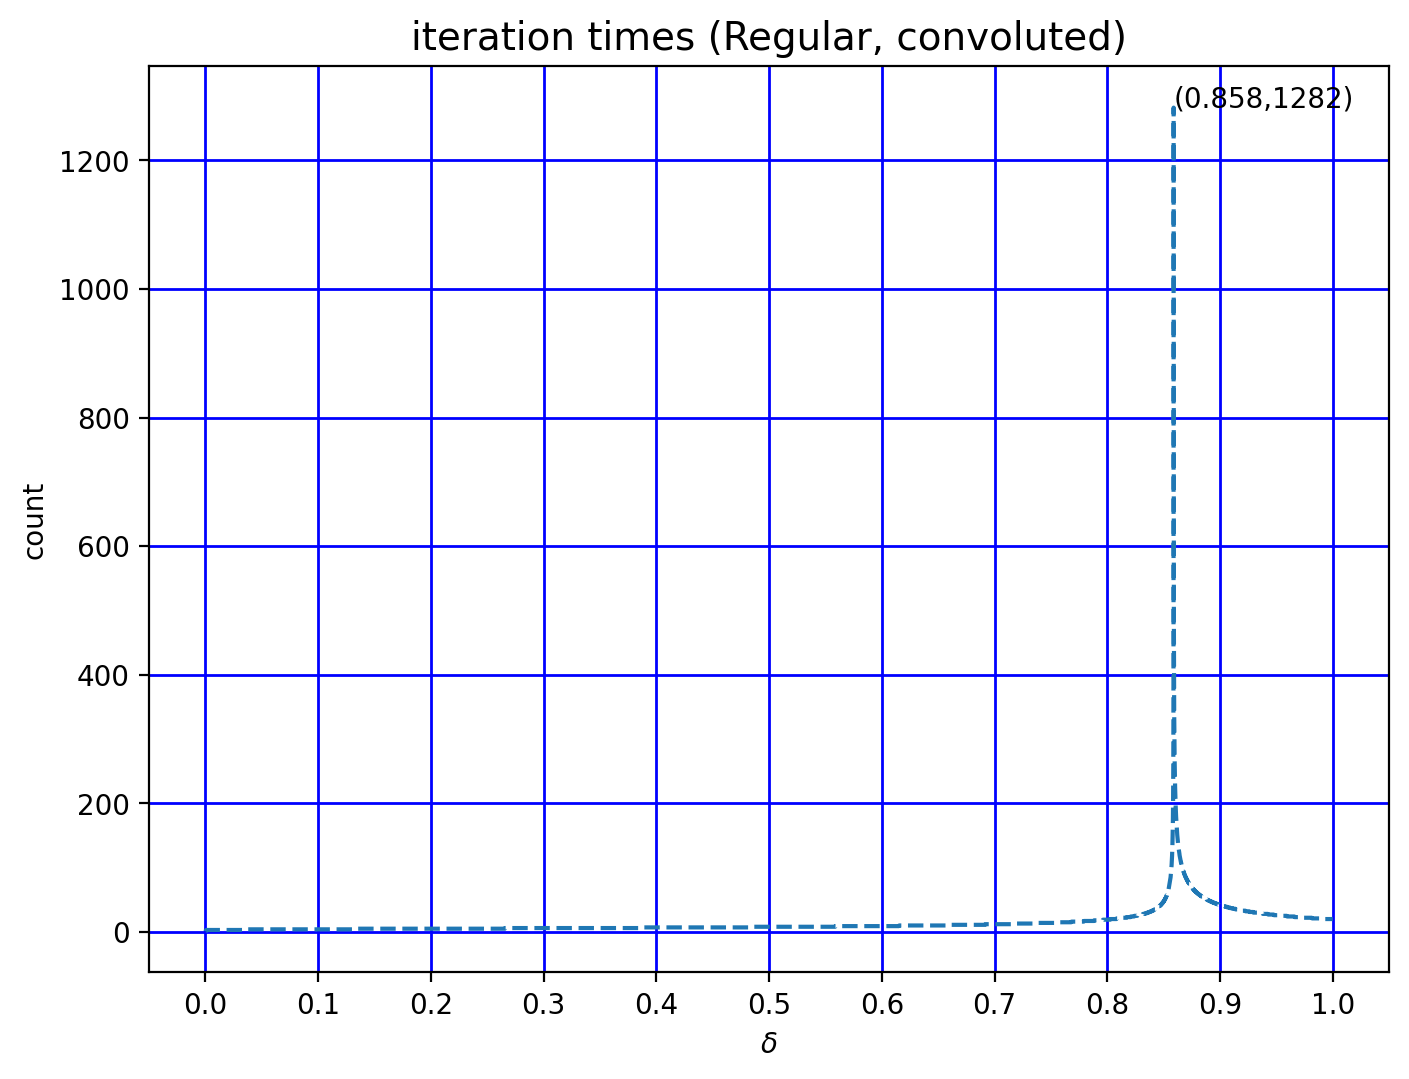

In [13]:
fig = plt.figure(figsize=(8,6), dpi=200)
plt.xticks(deltas_tick) # 設定刻度
plt.grid(color = 'blue', linestyle = '-', linewidth = 1) # 設定網格
plt.title('iteration times (Regular, convoluted)', fontsize = 14) # 標題
plt.xlabel(r'$\delta$') # x軸標題
plt.ylabel("count") # y軸標題
plt.plot(deltas, iter_L, '--')
x = deltas[iter_L.index(max(iter_L))]
y = max(iter_L)
plt.annotate('(' + str(x)[0:6] + ',' + str(y) + ')', (x,y))
plt.savefig(regular_dir + 'iteration_times_regular' + '_L=' + str(L) + '_eta=' + str(eta) + '_convoluted.png')
plt.show()

對照組：conventional

In [14]:
alpha_lines_con = [] 
beta_lines_con = [] 
iter_L = []

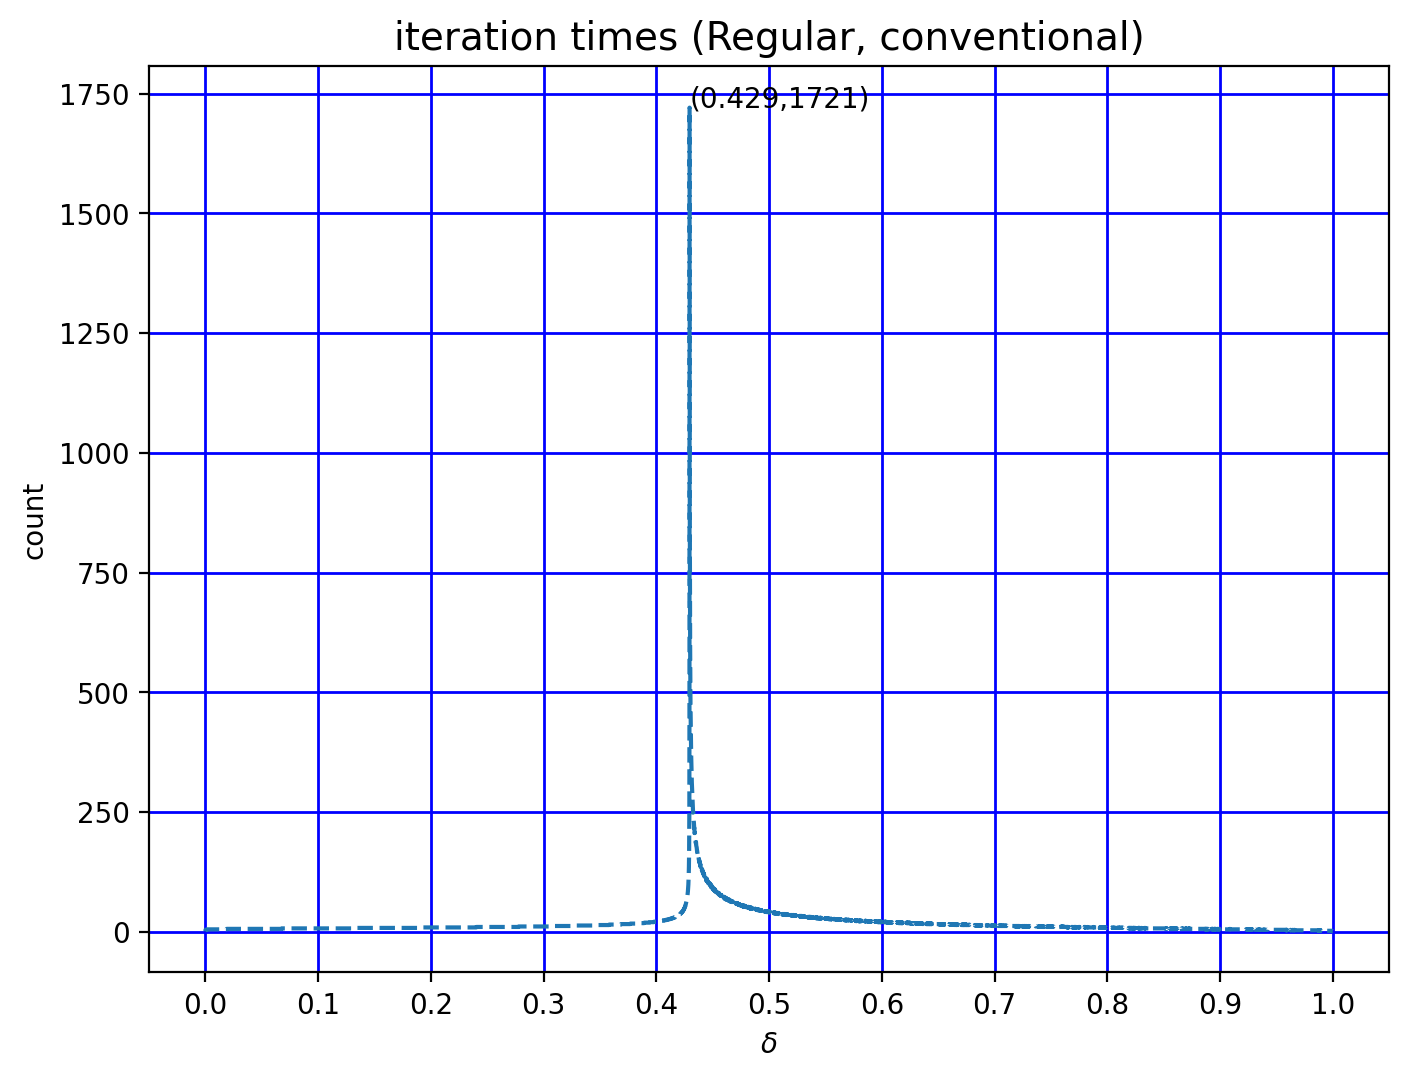

In [15]:
if (L==2):
    for delta in deltas: # 共1000個點
        alpha_d_i_con = [delta] # 每一點initial condition
        beta_d_i_con = [0] # beta的initial condition沒差
        for i in range(1,ITER_TIMES): # 每一點迭代1000次     
            b = 1 - rho(1-alpha_d_i_con[i-1])
            beta_d_i_con.append(b)
            a = delta * lambda_(1 - rho(1 - alpha_d_i_con[i-1]))       
            if (abs(alpha_d_i_con[-1]-a) <= 0):
                break        
            alpha_d_i_con.append(a)
            
        iter_L.append(i)
        alpha_lines_con.append(alpha_d_i_con[-1])
        beta_lines_con.append(beta_d_i_con[-1])
        
    
    fig = plt.figure(figsize=(8,6), dpi=200)
    plt.xticks(deltas_tick) # 設定刻度
    plt.grid(color = 'blue', linestyle = '-', linewidth = 1) # 設定網格
    plt.title('iteration times (Regular, conventional)', fontsize = 14) # 標題
    plt.xlabel(r'$\delta$') # x軸標題
    plt.ylabel("count") # y軸標題
    plt.plot(deltas, iter_L, '--')
    x = deltas[iter_L.index(max(iter_L))]
    y = max(iter_L)
    plt.annotate('(' + str(x)[0:6] + ',' + str(y) + ')', (x,y))
    plt.savefig(regular_dir + 'iteration_times_regular' + '_L=' + str(L) + '_eta=' + str(eta) + '_conventional.png')
    plt.show()

儲存紀錄

In [16]:
l=2
for lines in alpha_lines:
    dict = {'delta': deltas, 'alpha': lines}         
    df = pd.DataFrame(dict)
    df.to_csv(regular_dir + 'alpha_L=' + str(L) + '_' + str(l) + '.csv')
    l= l + 1

l=2
for lines in beta_lines:
    l=2
    dict = {'delta': deltas, 'beta': lines}         
    df = pd.DataFrame(dict)
    df.to_csv(regular_dir + 'beta_L=' + str(L) + '_' + str(l) + '.csv')
    l= l + 1
    
if (L==2):
    dict = {'delta': deltas, 'alpha': alpha_lines_con, 'beta': beta_lines_con}         
    df = pd.DataFrame(dict)
    df.to_csv(regular_dir + 'conventional' + '.csv') 

### (2) Irregular LDPC from example 1
實驗組：convoluted

In [17]:
iter_L = []
alpha_lines_irr = [] 
beta_lines_irr = [] 
for delta in tqdm(deltas): # 共1000個點
    alpha_d_i_irr = [[delta] * (L-1)] # 每一點initial condition
    beta_d_i_irr = [[0] * L] # beta的initial condition沒差
    for i in range(1,ITER_TIMES): # 每一點迭代1000次
        beta_d_i_c_irr = []
        for c in range(0, L): # beta共L條線, paper上的下標1代表此處的index c=0
            if (c==0):
                b = 1 - rho_irr(1 - (1 - eta) * alpha_d_i_irr[i-1][0])
            elif (c==L-1):
                b = 1 - rho_irr(1 - eta * alpha_d_i_irr[i-1][L-2])
            else:
                b = 1 - rho_irr(1 - (1-eta) * alpha_d_i_irr[i-1][c] - eta * alpha_d_i_irr[i-1][c-1])
            beta_d_i_c_irr.append(b)
            
        beta_d_i_irr.append(beta_d_i_c_irr)
        
        alpha_d_i_v_irr = []
        for v in range(0, L-1): # alpha共L-1條線, paper上的下標1代表此處的index v=0
            a = delta * lambda_irr((1-eta) * beta_d_i_irr[i][v] + eta * beta_d_i_irr[i][v+1])
            alpha_d_i_v_irr.append(a)

        diff_a = []
        for x,y in zip(alpha_d_i_irr[-1], alpha_d_i_v_irr):
            diff_a.append(abs(x-y))
        if (all(d <= 1e-8 for d in diff_a)):
            break
        
        alpha_d_i_irr.append(alpha_d_i_v_irr)
    alpha_lines_irr.append(alpha_d_i_irr[-1])
    beta_lines_irr.append(beta_d_i_irr[-1])
    iter_L.append(i)
alpha_lines_irr = np.array(alpha_lines_irr).transpose()
beta_lines_irr = np.array(beta_lines_irr).transpose()

100%|███████████████████████████████████| 10001/10001 [00:01<00:00, 6737.83it/s]


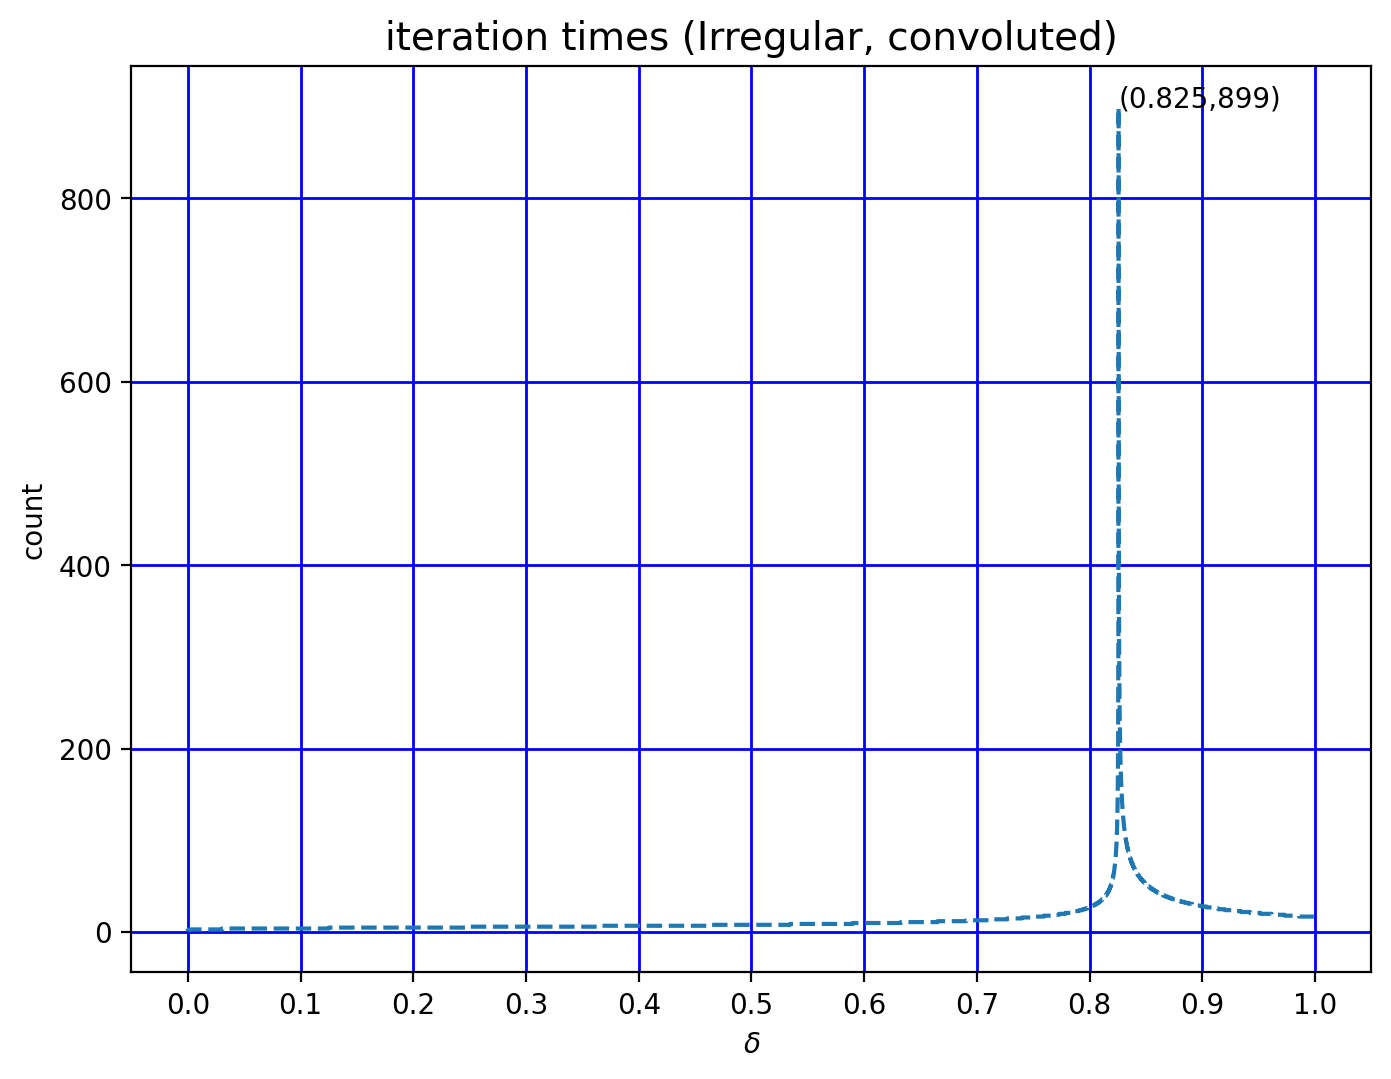

In [18]:
fig = plt.figure(figsize=(8,6), dpi=200)
plt.xticks(deltas_tick) # 設定刻度
plt.grid(color = 'blue', linestyle = '-', linewidth = 1) # 設定網格
plt.title('iteration times (Irregular, convoluted)', fontsize = 14) # 標題
plt.xlabel(r'$\delta$') # x軸標題
plt.ylabel("count") # y軸標題
plt.plot(deltas, iter_L, '--')
x = deltas[iter_L.index(max(iter_L))]
y = max(iter_L)
plt.annotate('(' + str(x)[0:6] + ',' + str(y) + ')', (x,y))
plt.savefig(irregular_dir + 'iteration_times_irregular' + '_L=' + str(L) + '_eta=' + str(eta) + '_convoluted.png')
plt.show()

對照組：conventional

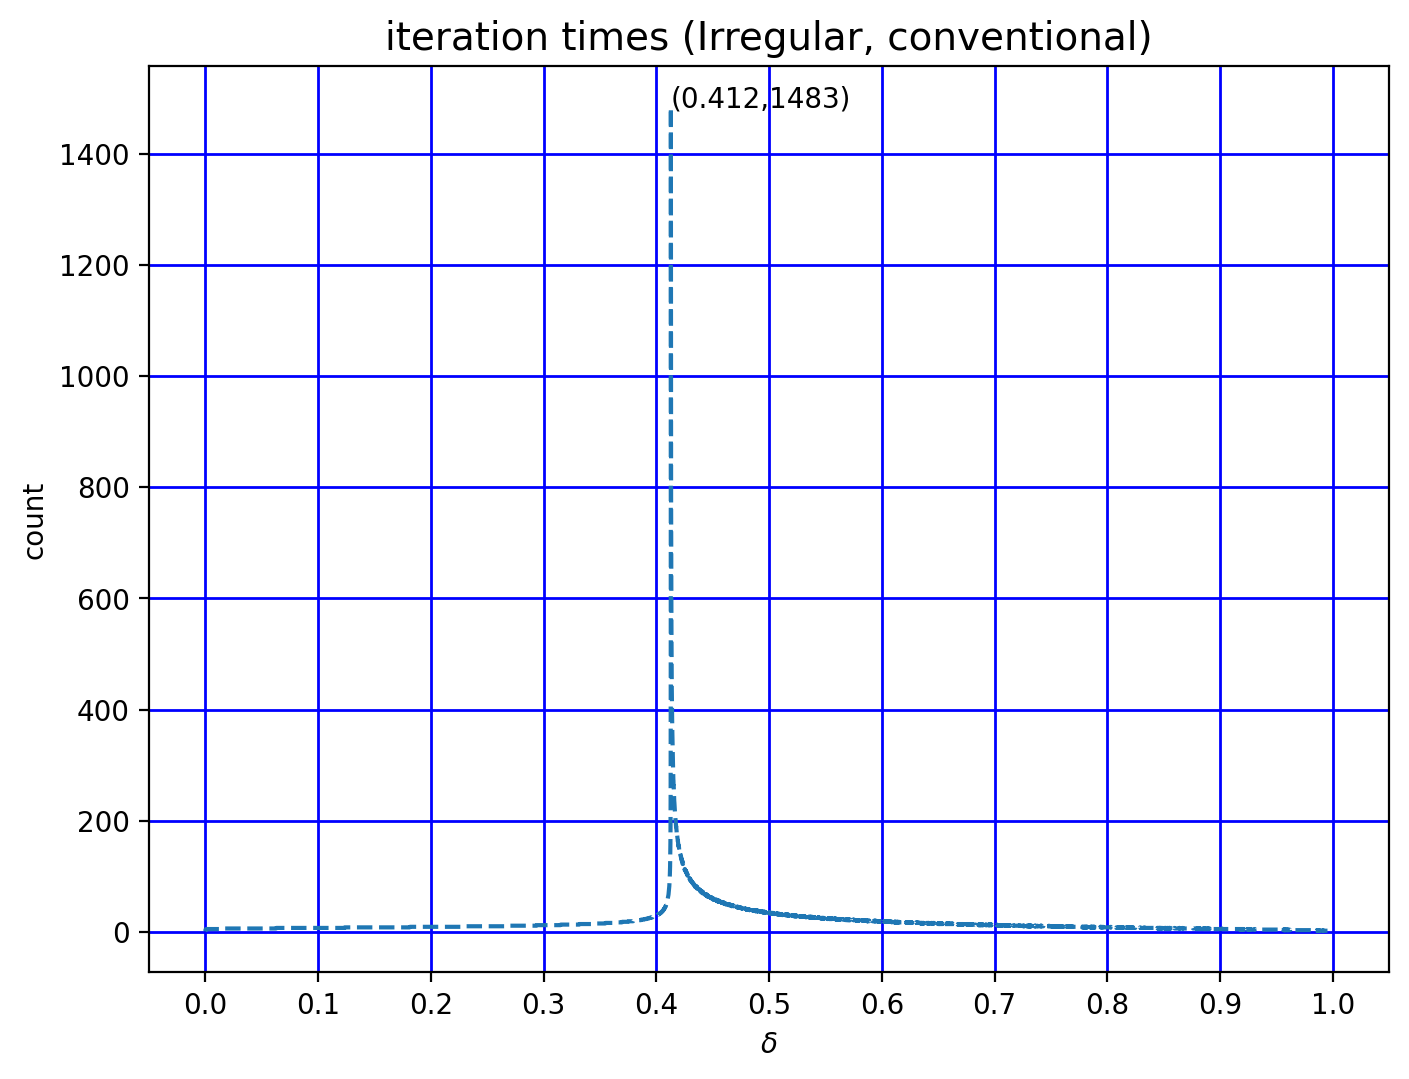

In [19]:
if (L==2):
    iter_L = []
    alpha_lines_irr_con = [] 
    beta_lines_irr_con = [] 
    for delta in deltas: # 共1000個點
        alpha_d_i_irr_con = [delta] # 每一點initial condition
        beta_d_i_irr_con = [0] # beta的initial condition沒差
        for i in range(1,ITER_TIMES): # 每一點迭代1000次     
            b = 1 - rho_irr(1-alpha_d_i_irr_con[i-1])
            beta_d_i_irr_con.append(b)
            a = delta * lambda_irr(1 - rho_irr(1 - alpha_d_i_irr_con[i-1]))
            if (abs(alpha_d_i_irr_con[-1]-a) <= 0):
                break        
            alpha_d_i_irr_con.append(a)
        
        iter_L.append(i)
        alpha_lines_irr_con.append(alpha_d_i_irr_con[-1])
        beta_lines_irr_con.append(beta_d_i_irr_con[-1])
        
    fig = plt.figure(figsize=(8,6), dpi=200)
    plt.xticks(deltas_tick) # 設定刻度
    plt.grid(color = 'blue', linestyle = '-', linewidth = 1) # 設定網格
    plt.title('iteration times (Irregular, conventional)', fontsize = 14) # 標題
    plt.xlabel(r'$\delta$') # x軸標題
    plt.ylabel("count") # y軸標題
    plt.plot(deltas, iter_L, '--')
    x = deltas[iter_L.index(max(iter_L))]
    y = max(iter_L)
    plt.annotate('(' + str(x)[0:6] + ',' + str(y) + ')', (x,y))
    plt.savefig(irregular_dir + 'iteration_times_irregular' + '_L=' + str(L) + '_eta=' + str(eta) + '_conventional.png')
    plt.show()

儲存紀錄

In [20]:
l=2
for lines in alpha_lines_irr:
    dict = {'delta': deltas, 'alpha': lines}         
    df = pd.DataFrame(dict)
    df.to_csv(irregular_dir + 'alpha_L=' + str(L) + '_' + str(l) + '.csv')
    l= l + 1

l=2
for lines in beta_lines_irr:
    l=2
    dict = {'delta': deltas, 'beta': lines}         
    df = pd.DataFrame(dict)
    df.to_csv(irregular_dir + 'beta_L=' + str(L) + '_' + str(l) + '.csv')
    l= l + 1
    
if (L==2):
    dict = {'delta': deltas, 'alpha': alpha_lines_irr_con, 'beta': beta_lines_irr_con}         
    df = pd.DataFrame(dict)
    df.to_csv(irregular_dir + 'conventional' + '.csv') 

### (3) Shokrollahi's generating function
實驗組：convoluted

In [ ]:
iter_L = []
alpha_lines_sho = [] 
beta_lines_sho = [] 
for delta in tqdm(deltas): # 共1000個點
    alpha_d_i_sho = [[delta] * (L-1)] # 每一點initial condition
    beta_d_i_sho = [[0] * L] # beta的initial condition沒差
    for i in range(1,ITER_TIMES): # 每一點迭代2000次
        beta_d_i_c_sho = []
        for c in range(0, L): # beta共L條線, paper上的下標1代表此處的index c=0
            if (c==0):
                b = 1 - rho_sho(1 - (1 - eta) * alpha_d_i_sho[i-1][0])
            elif (c==L-1):
                b = 1 - rho_sho(1 - eta * alpha_d_i_sho[i-1][L-2])
            else:
                b = 1 - rho_sho(1 - (1-eta) * alpha_d_i_sho[i-1][c] - eta * alpha_d_i_sho[i-1][c-1])
            beta_d_i_c_sho.append(b)
            
        beta_d_i_sho.append(beta_d_i_c_sho)
        
        alpha_d_i_v_sho = []
        for v in range(0, L-1): # alpha共L-1條線, paper上的下標1代表此處的index v=0
            a = delta * lambda_sho((1-eta) * beta_d_i_sho[i][v] + eta * beta_d_i_sho[i][v+1])
            alpha_d_i_v_sho.append(a)
        #print(alpha_d_i_v_sho) #check convergence
        diff_a = []
        for x,y in zip(alpha_d_i_sho[-1], alpha_d_i_v_sho):
            diff_a.append(abs(x-y))
        if (all(d <= 1e-8 for d in diff_a)):
            break
        alpha_d_i_sho.append(alpha_d_i_v_sho)
    
    alpha_lines_sho.append(alpha_d_i_sho[-1])
    beta_lines_sho.append(beta_d_i_sho[-1])
    iter_L.append(i)
alpha_lines_sho = np.array(alpha_lines_sho).transpose()
beta_lines_sho = np.array(beta_lines_sho).transpose()

 47%|████████████████████████████████████▎                                        | 4719/10001 [02:23<14:28,  6.08it/s]

In [ ]:
fig = plt.figure(figsize=(8,6), dpi=200)
plt.xticks(deltas_tick) # 設定刻度
plt.grid(color = 'blue', linestyle = '-', linewidth = 1) # 設定網格
plt.title('iteration times (Shokrollahi, convoluted)', fontsize = 14) # 標題
plt.xlabel(r'$\delta$') # x軸標題
plt.ylabel("count") # y軸標題
plt.plot(deltas, iter_L, '--')
x = deltas[iter_L.index(max(iter_L))]
y = max(iter_L)
plt.annotate('(' + str(x)[0:6] + ',' + str(y) + ')', (x,y))
plt.savefig(sho_dir + 'iteration_times_sho' + '_L=' + str(L) + '_eta=' + str(eta) + '_convoluted.png')
plt.show()

對照組：conventional

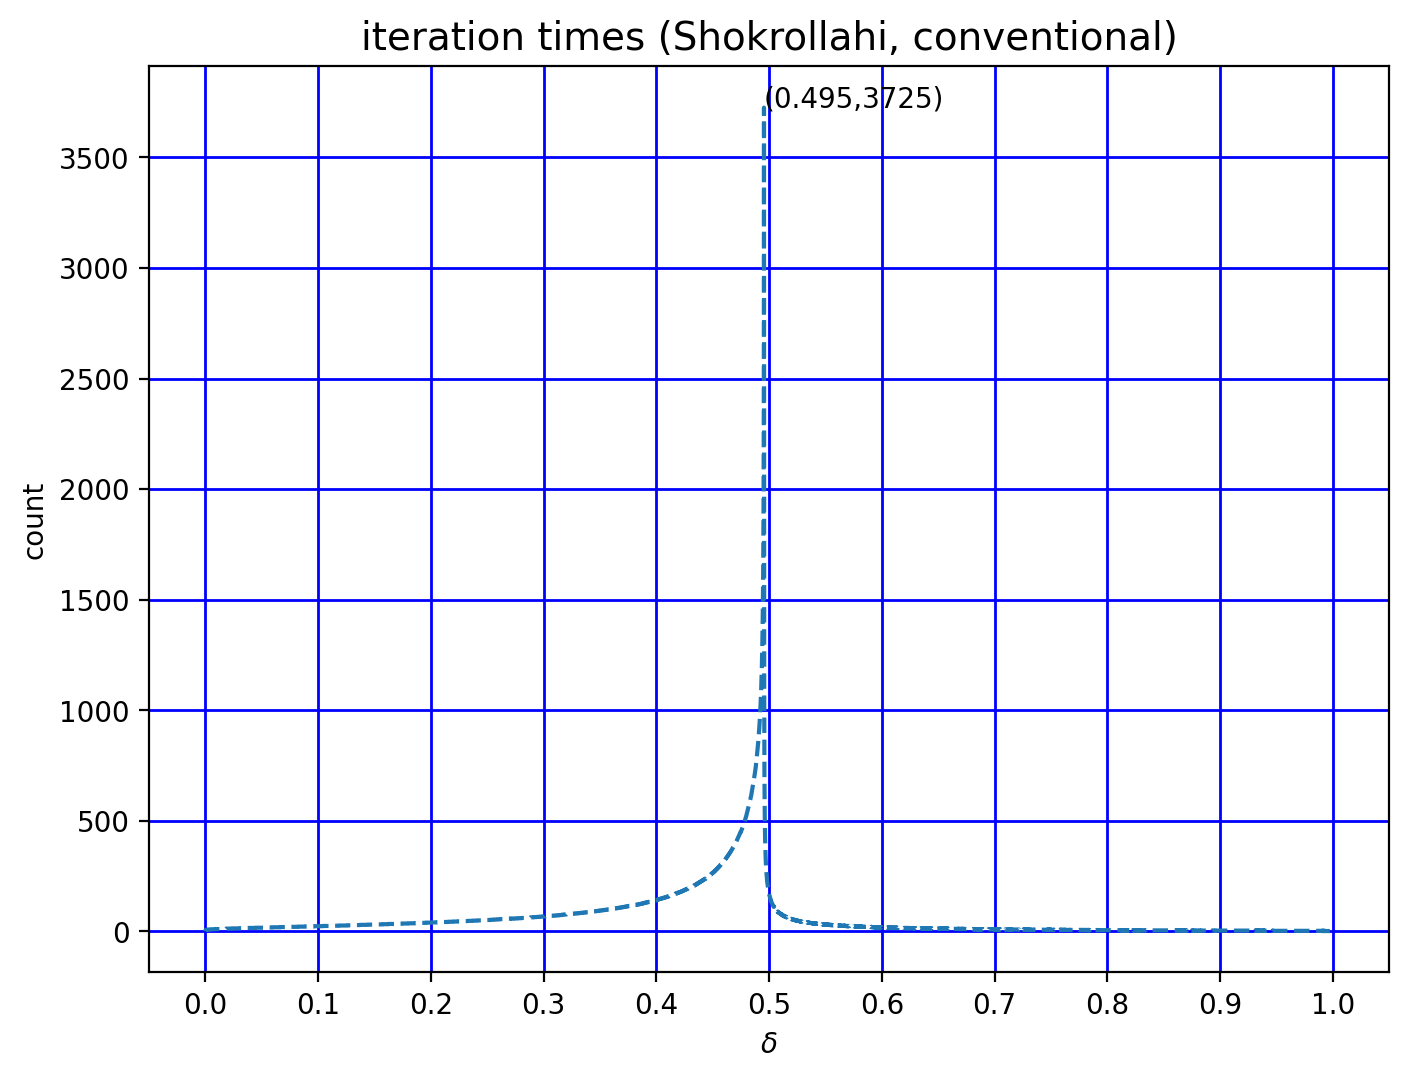

In [23]:
iter_L = []
if (L==2):
    alpha_lines_sho_con = [] 
    beta_lines_sho_con = [] 
    for delta in deltas: # 共1000個點
        alpha_d_i_sho_con = [delta] # 每一點initial condition
        beta_d_i_sho_con = [0] # beta的initial condition沒差
        for i in range(1,ITER_TIMES): # 每一點迭代500次     
            b = 1 - rho_sho(1-alpha_d_i_sho_con[i-1])
            beta_d_i_sho_con.append(b)
            a = delta * lambda_sho(1 - rho_sho(1 - alpha_d_i_sho_con[i-1]))
            if (abs(alpha_d_i_sho_con[-1]-a) <= 0):
                break    
            alpha_d_i_sho_con.append(a)

        iter_L.append(i)
        alpha_lines_sho_con.append(alpha_d_i_sho_con[-1])
        beta_lines_sho_con.append(beta_d_i_sho_con[-1])
        
    fig = plt.figure(figsize=(8,6), dpi=200)
    plt.xticks(deltas_tick) # 設定刻度
    plt.grid(color = 'blue', linestyle = '-', linewidth = 1) # 設定網格
    plt.title('iteration times (Shokrollahi, conventional)', fontsize = 14) # 標題
    plt.xlabel(r'$\delta$') # x軸標題
    plt.ylabel("count") # y軸標題
    plt.plot(deltas, iter_L, '--')
    x = deltas[iter_L.index(max(iter_L))]
    y = max(iter_L)
    plt.annotate('(' + str(x)[0:6] + ',' + str(y) + ')', (x,y))
    plt.savefig(sho_dir + 'iteration_times_sho' + '_L=' + str(L) + '_eta=' + str(eta) + '_conventional.png')
    plt.show()

儲存紀錄

In [24]:
l=2
for lines in alpha_lines_sho:
    dict = {'delta': deltas, 'alpha': lines}         
    df = pd.DataFrame(dict)
    df.to_csv(sho_dir + 'alpha_L=' + str(L) + '_' + str(l) + '.csv')
    l= l + 1

l=2
for lines in beta_lines_sho:
    l=2
    dict = {'delta': deltas, 'beta': lines}         
    df = pd.DataFrame(dict)
    df.to_csv(sho_dir + 'beta_L=' + str(L) + '_' + str(l) + '.csv')
    l= l + 1
    
if (L==2):
    dict = {'delta': deltas, 'alpha': alpha_lines_sho_con, 'beta': beta_lines_sho_con}         
    df = pd.DataFrame(dict)
    df.to_csv(sho_dir + 'conventional' + '.csv') 

### (4) Richardson's generating function
實驗組：convoluted

In [25]:
iter_L = []
alpha_lines_rich = [] 
beta_lines_rich = [] 
for delta in tqdm(deltas): # 共1000個點
    alpha_d_i_rich = [[delta] * (L-1)] # 每一點initial condition
    beta_d_i_rich = [[0] * L] # beta的initial condition沒差
    for i in range(1,ITER_TIMES): # 每一點迭代500次
        beta_d_i_c_rich = []
        for c in range(0, L): # beta共L條線, paper上的下標1代表此處的index c=0
            if (c==0):
                b = 1 - rho_rich(1 - (1 - eta) * alpha_d_i_rich[i-1][0])
            elif (c==L-1):
                b = 1 - rho_rich(1 - eta * alpha_d_i_rich[i-1][L-2])
            else:
                b = 1 - rho_rich(1 - (1-eta) * alpha_d_i_rich[i-1][c] - eta * alpha_d_i_rich[i-1][c-1])
            beta_d_i_c_rich.append(b)
            
        beta_d_i_rich.append(beta_d_i_c_rich)
        
        alpha_d_i_v_rich = []
        for v in range(0, L-1): # alpha共L-1條線, paper上的下標1代表此處的index v=0
            a = delta * lambda_rich((1-eta) * beta_d_i_rich[i][v] + eta * beta_d_i_rich[i][v+1])
            alpha_d_i_v_rich.append(a)
        #print(alpha_d_i_v_rich) #check convergence
        diff_a = []
        for x,y in zip(alpha_d_i_rich[-1], alpha_d_i_v_rich):
            diff_a.append(abs(x-y))
        if (all(d <= 1e-8 for d in diff_a)):
            break
        alpha_d_i_rich.append(alpha_d_i_v_rich)
        
    alpha_lines_rich.append(alpha_d_i_rich[-1])
    beta_lines_rich.append(beta_d_i_rich[-1])
    iter_L.append(i)
alpha_lines_rich = np.array(alpha_lines_rich).transpose()
beta_lines_rich = np.array(beta_lines_rich).transpose()

100%|███████████████████████████████████| 10001/10001 [00:02<00:00, 3961.97it/s]


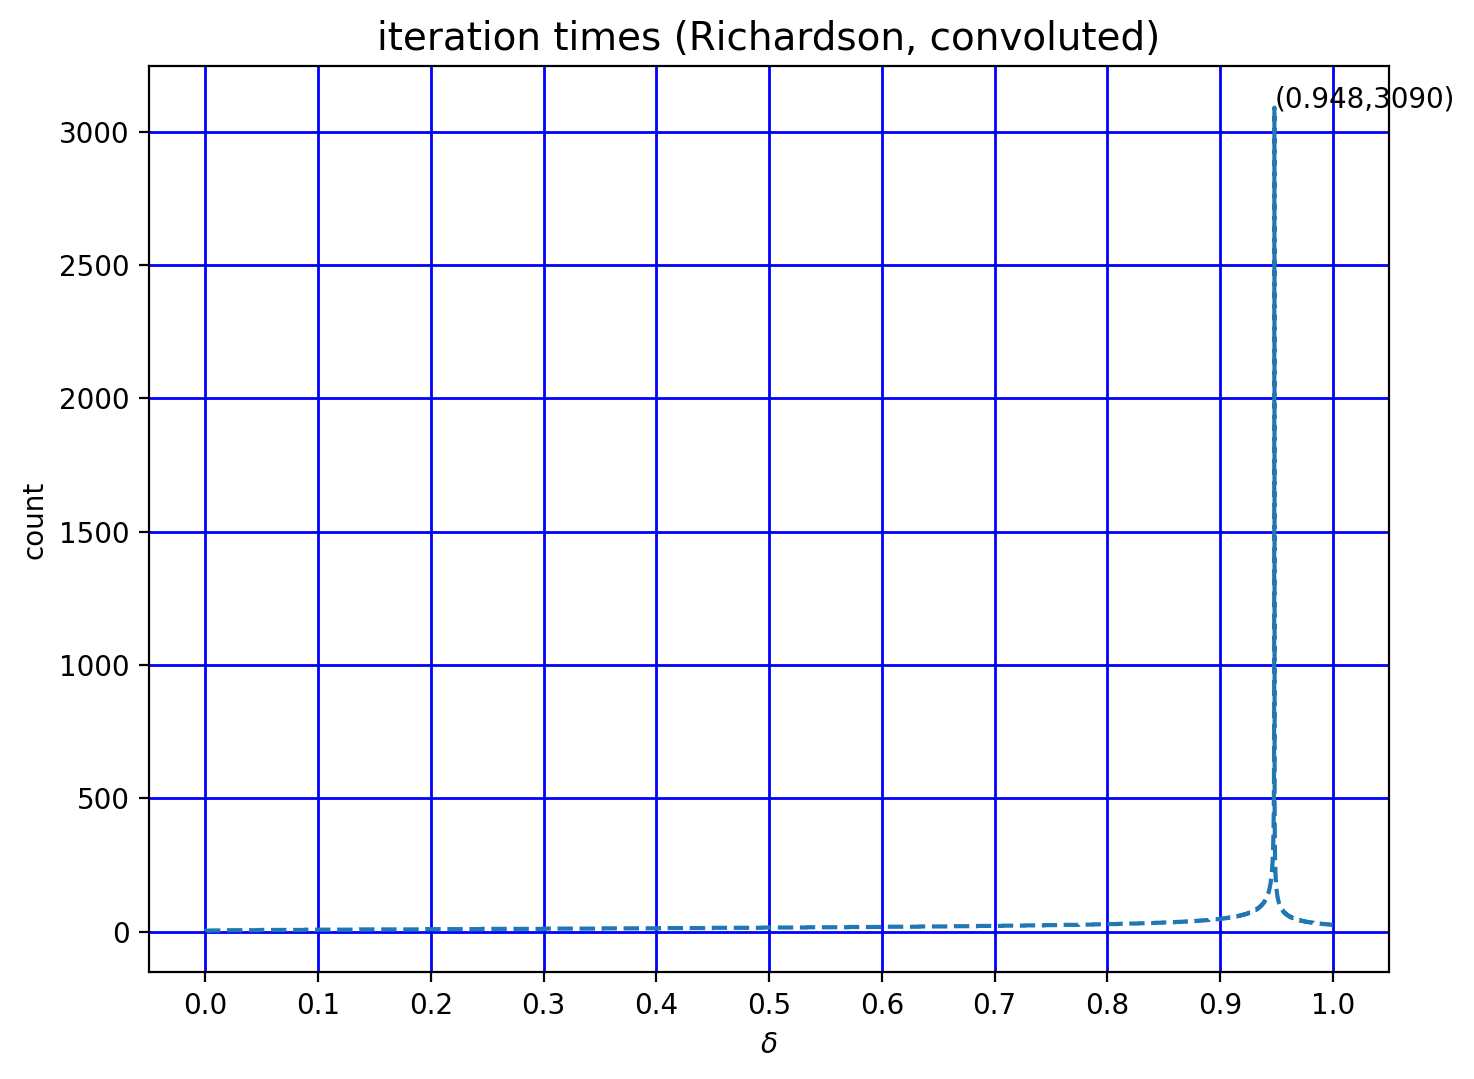

In [26]:
fig = plt.figure(figsize=(8,6), dpi=200)
plt.xticks(deltas_tick) # 設定刻度
plt.grid(color = 'blue', linestyle = '-', linewidth = 1) # 設定網格
plt.title('iteration times (Richardson, convoluted)', fontsize = 14) # 標題
plt.xlabel(r'$\delta$') # x軸標題
plt.ylabel("count") # y軸標題
plt.plot(deltas, iter_L, '--')
x = deltas[iter_L.index(max(iter_L))]
y = max(iter_L)
plt.annotate('(' + str(x)[0:6] + ',' + str(y) + ')', (x,y))
plt.savefig(rich_dir + 'iteration_times_rich' + '_L=' + str(L) + '_eta=' + str(eta) + '_convoluted.png')
plt.show()

對照組：conventional

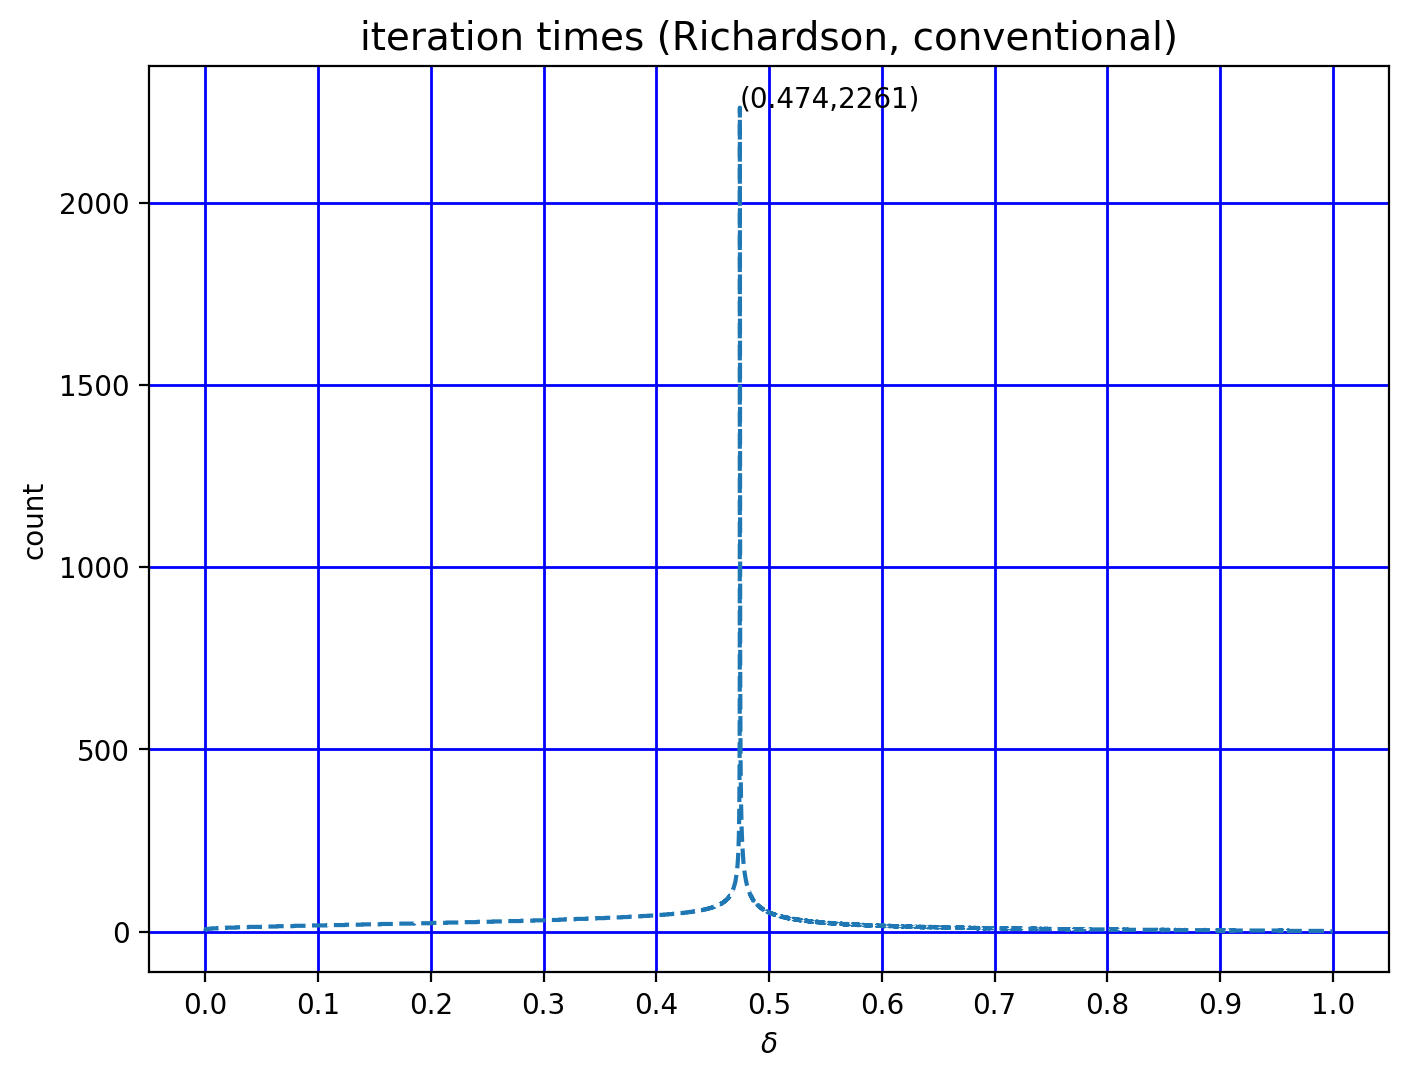

In [27]:
iter_L = []
if (L==2):
    alpha_lines_rich_con = [] 
    beta_lines_rich_con = []
    for delta in deltas: # 共1000個點
        alpha_d_i_rich_con = [delta] # 每一點initial condition
        beta_d_i_rich_con = [0] # beta的initial condition沒差
        for i in range(1,ITER_TIMES): # 每一點迭代500次     
            b = 1 - rho_rich(1-alpha_d_i_rich_con[i-1])
            beta_d_i_rich_con.append(b)
            a = delta * lambda_rich(1 - rho_rich(1 - alpha_d_i_rich_con[i-1]))
            if (abs(alpha_d_i_rich_con[-1]-a) <= 0):
                break    
            alpha_d_i_rich_con.append(a)
        #print(alpha_d_i_rich_con)
        
        iter_L.append(i)
        alpha_lines_rich_con.append(alpha_d_i_rich_con[-1])
        beta_lines_rich_con.append(beta_d_i_rich_con[-1])
    
    fig = plt.figure(figsize=(8,6), dpi=200)
    plt.xticks(deltas_tick) # 設定刻度
    plt.grid(color = 'blue', linestyle = '-', linewidth = 1) # 設定網格
    plt.title('iteration times (Richardson, conventional)', fontsize = 14) # 標題
    plt.xlabel(r'$\delta$') # x軸標題
    plt.ylabel("count") # y軸標題
    plt.plot(deltas, iter_L, '--')
    x = deltas[iter_L.index(max(iter_L))]
    y = max(iter_L)
    plt.annotate('(' + str(x)[0:6] + ',' + str(y) + ')', (x,y))
    plt.savefig(rich_dir + 'iteration_times_rich' + '_L=' + str(L) + '_eta=' + str(eta) + '_conventional.png')
    plt.show()

儲存紀錄

In [28]:
l=2
for lines in alpha_lines_rich:
    dict = {'delta': deltas, 'alpha': lines}         
    df = pd.DataFrame(dict)
    df.to_csv(rich_dir + 'alpha_L=' + str(L) + '_' + str(l) + '.csv')
    l= l + 1

l=2
for lines in beta_lines_rich:
    l=2
    dict = {'delta': deltas, 'beta': lines}         
    df = pd.DataFrame(dict)
    df.to_csv(rich_dir + 'beta_L=' + str(L) + '_' + str(l) + '.csv')
    l= l + 1
    
if (L==2):
    dict = {'delta': deltas, 'alpha': alpha_lines_rich_con, 'beta': beta_lines_rich_con}         
    df = pd.DataFrame(dict)
    df.to_csv(rich_dir + 'conventional' + '.csv') 

## 4. Plotting
### (1) Regular LDPC

In [29]:
if (L<10):
    alpha_range = list(range(0,L-1))
    beta_range = list(range(0,L))
elif (L==10):
    alpha_range = [0,1,2,3,4]
    beta_range = [0,1,2,3,4]
else:
    alpha_range = [0, int(L/10)-1, int(2*L/10)-1, int(3*L/10)-1, int(4*L/10)-1, int(L/2)-1]
    beta_range = [0, int(L/10)-1, int(2*L/10)-1, int(3*L/10)-1, int(4*L/10)-1, int(L/2)-1]

In [30]:
if (L != 2):
    col_list = ["delta", "alpha", "beta"]
    df = pd.read_csv(regular_dir + 'conventional' + '.csv', usecols=col_list)
    alpha_lines_con = list(df["alpha"])
    beta_lines_con = list(df["beta"])

In [31]:
metrics = [alpha_lines, beta_lines]
metrics_str = ['av_limit', 'bc_limit']
metrics_LaTeX = [r'$\lim_{i\to\infty}\alpha_v^{(i)}$',
                 r'$\lim_{i\to\infty}\beta_c^{(i)}$']

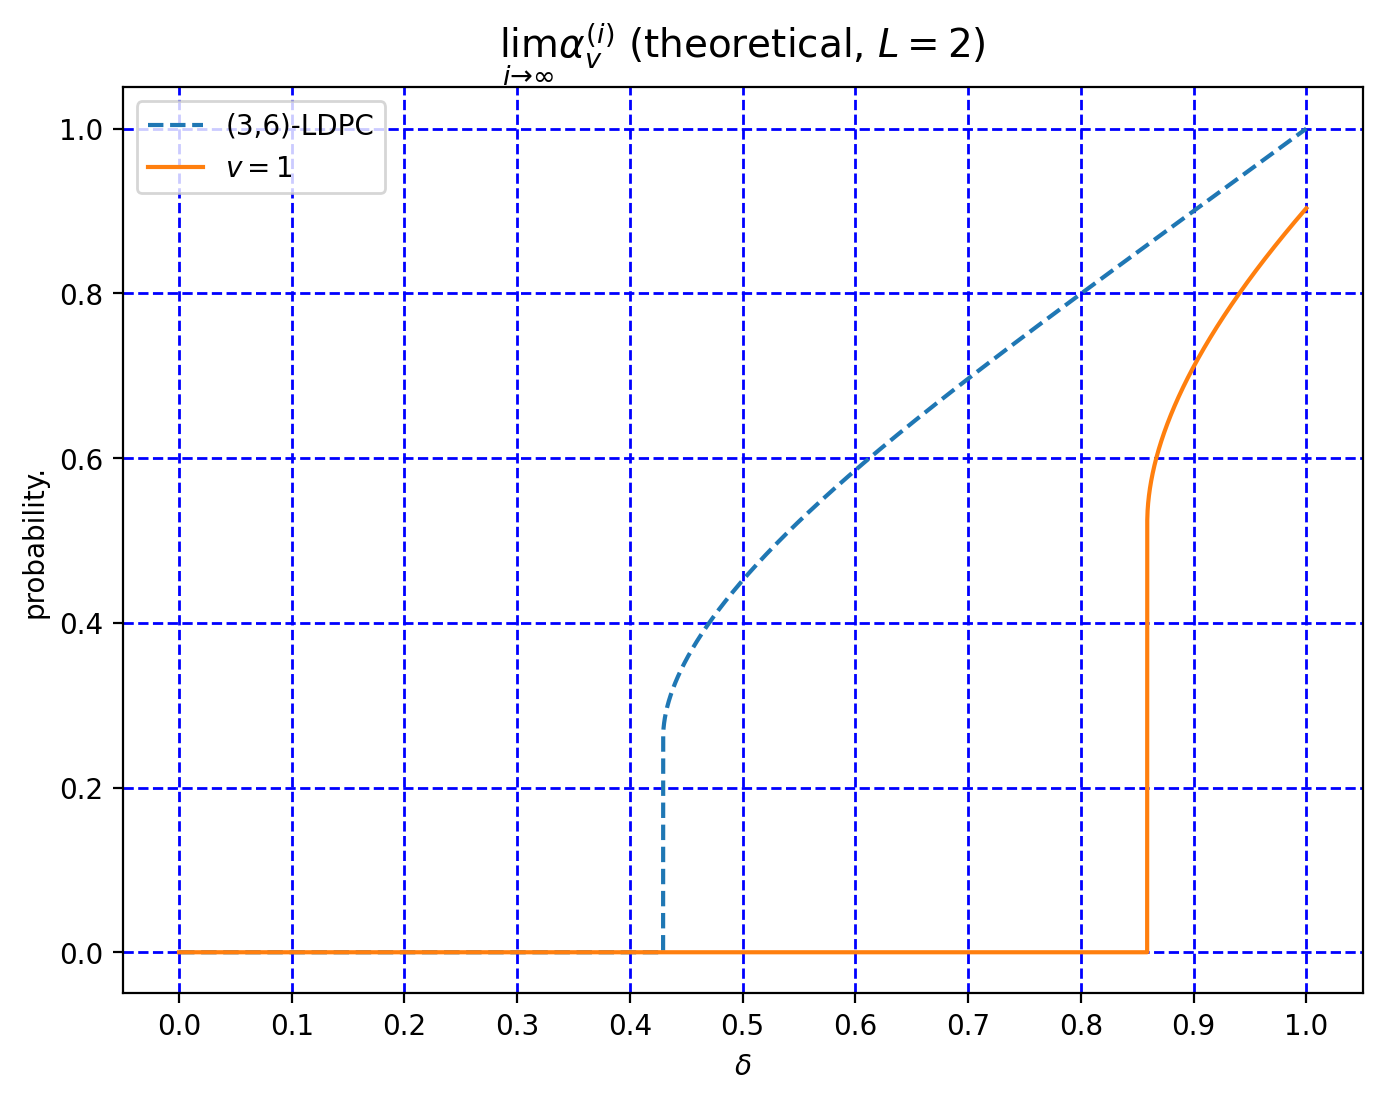

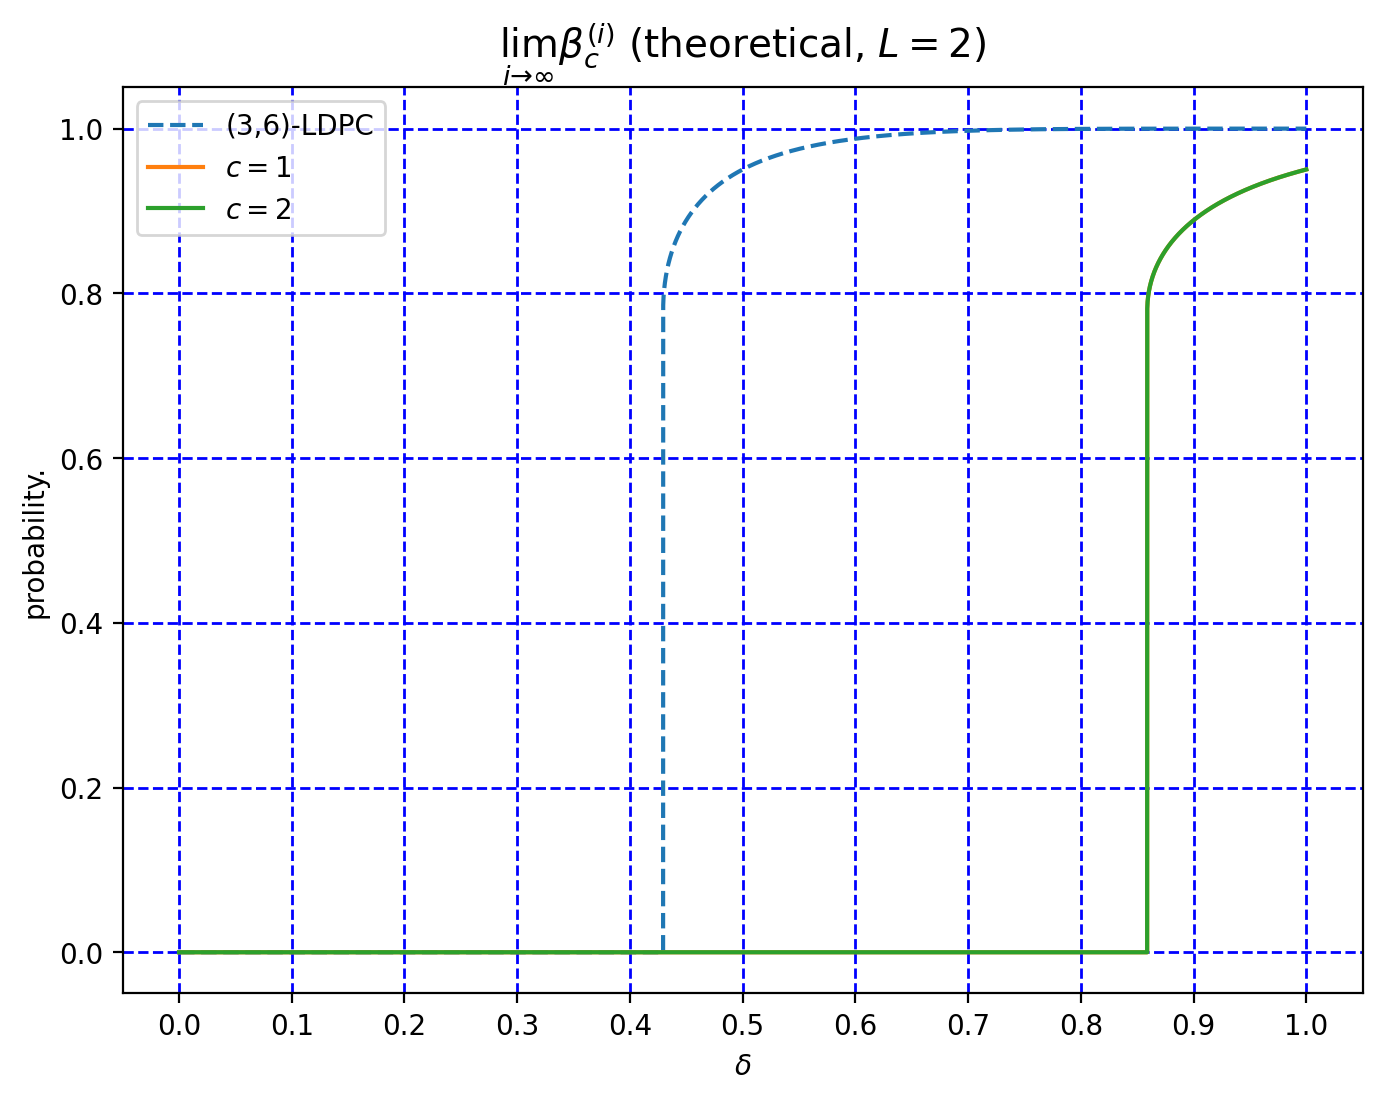

In [32]:
for m, m_str, m_latex in zip(metrics, metrics_str, metrics_LaTeX):
    fig = plt.figure(figsize=(8,6), dpi=200)

    plt.xticks(deltas_tick) # 設定刻度
    plt.grid(color = 'blue', linestyle = '--', linewidth = 1) # 設定網格
    plt.title(m_latex + ' (theoretical, ' + r'$L=$' + str(L) + ')', fontsize = 14) # 標題
    plt.xlabel(r'$\delta$') # x軸標題
    plt.ylabel("probability.") # y軸標題

    colormap = plt.cm.gist_ncar # 顏色輪流出現
    
    lines = []
    
    if (m_str=='av_limit'):
        original_line = plt.plot(deltas, alpha_lines_con, '--')
        for data, l in zip(m, alpha_range):
            line = plt.plot(deltas, data, '-')
            lines.append(r'$v=$' + str(l+1))
        lines.insert(0, '(3,6)-LDPC')
        plt.legend(lines)
    else:
        original_line = plt.plot(deltas, beta_lines_con, '--')
        for data, l in zip(m, beta_range):
            line = plt.plot(deltas, data, '-')
            lines.append(r'$c=$' + str(l+1))
        lines.insert(0, '(3,6)-LDPC')
        plt.legend(lines)
    
    plt.savefig(regular_dir + m_str + '_L=' + str(L) + '_eta=' + str(eta) + '_theoretical.png')
    plt.show()

### (2) Irregular convoluted (example 1)

In [33]:
if (L != 2):
    col_list = ["delta", "alpha", "beta"]
    df = pd.read_csv(irregular_dir + 'conventional' + '.csv', usecols=col_list)
    alpha_lines_irr_con = df["alpha"]
    beta_lines_irr_con = df["beta"]

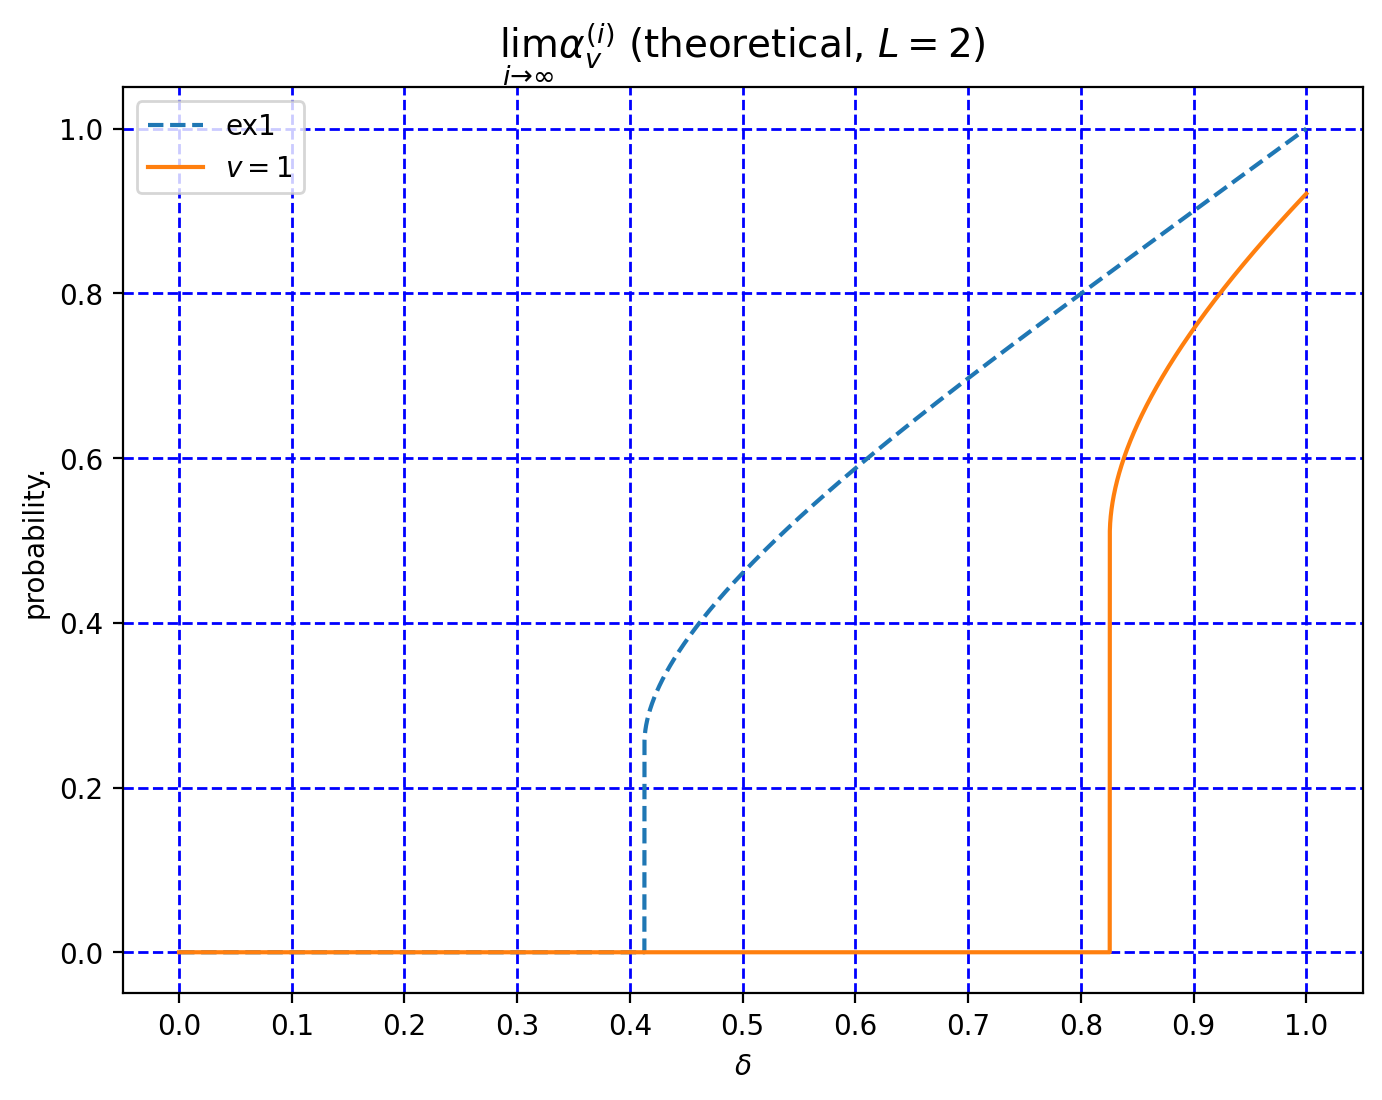

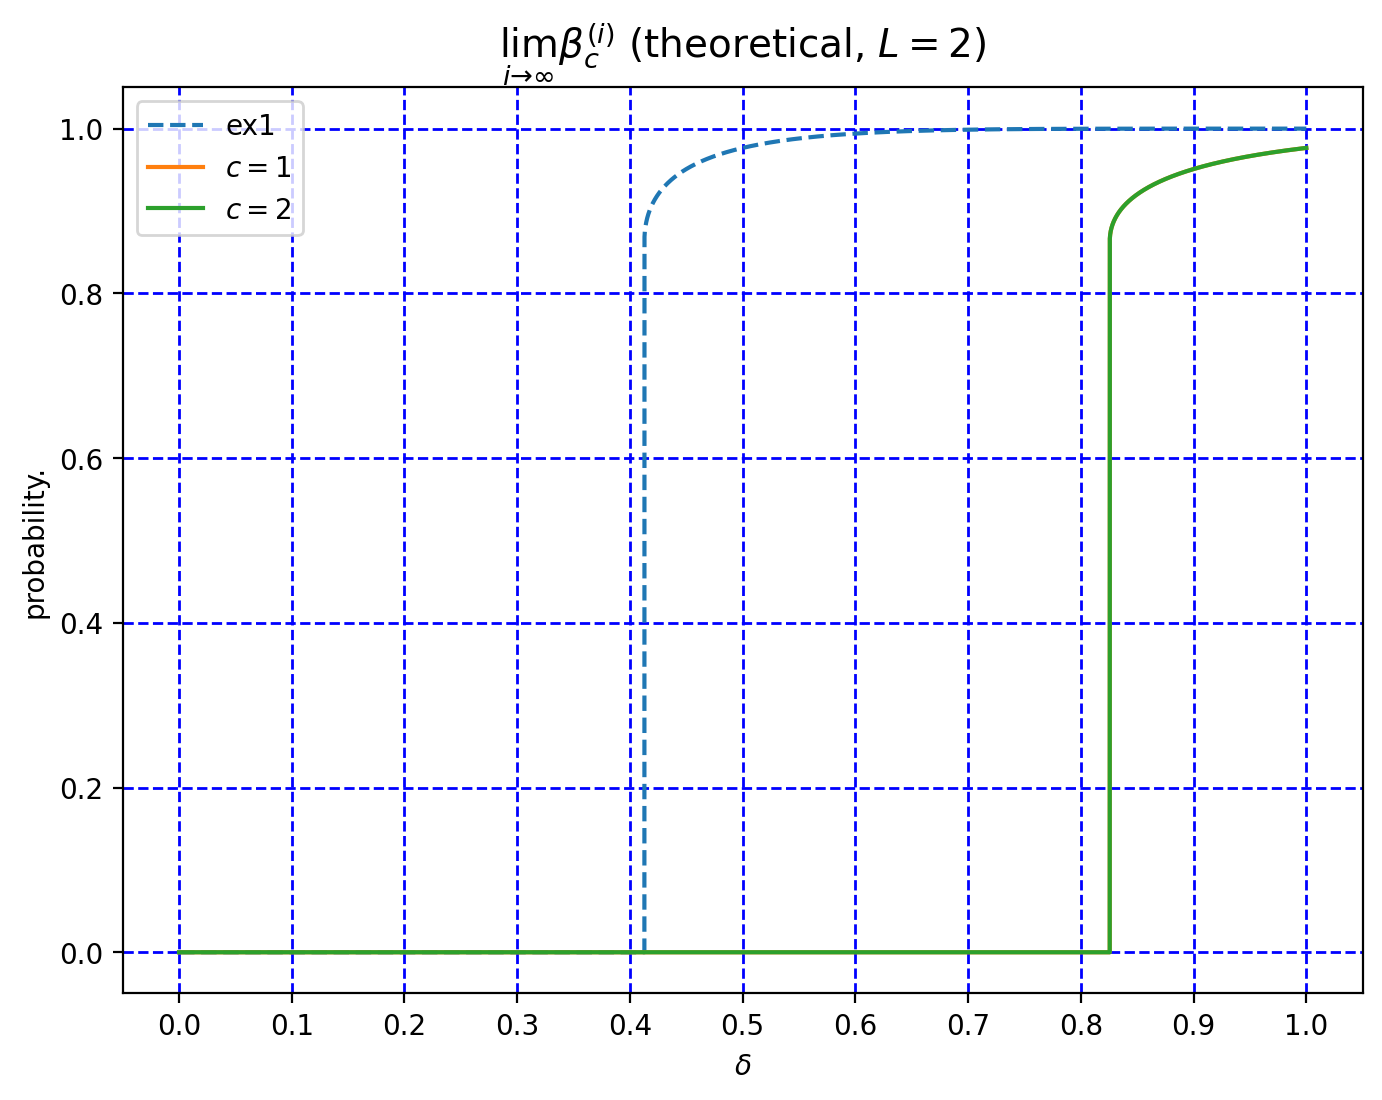

In [34]:
metrics = [alpha_lines_irr, beta_lines_irr]
metrics_str = ['av_limit', 'bc_limit']
metrics_LaTeX = [r'$\lim_{i\to\infty}\alpha_v^{(i)}$',
                 r'$\lim_{i\to\infty}\beta_c^{(i)}$']

for m, m_str, m_latex in zip(metrics, metrics_str, metrics_LaTeX):
    fig = plt.figure(figsize=(8,6), dpi=200)

    plt.xticks(deltas_tick) # 設定刻度
    plt.grid(color = 'blue', linestyle = '--', linewidth = 1) # 設定網格
    plt.title(m_latex + ' (theoretical, ' + r'$L=$' + str(L) + ')', fontsize = 14) # 標題
    plt.xlabel(r'$\delta$') # x軸標題
    plt.ylabel("probability.") # y軸標題

    colormap = plt.cm.gist_ncar # 顏色輪流出現
    
    lines = []
    
    if (m_str=='av_limit'):
        original_line = plt.plot(deltas, alpha_lines_irr_con, '--')
        for data, l in zip(m, alpha_range):
            line = plt.plot(deltas, data, '-')
            lines.append(r'$v=$' + str(l+1))
        lines.insert(0, 'ex1')
        plt.legend(lines)
    else:
        original_line = plt.plot(deltas, beta_lines_irr_con, '--')
        for data, l in zip(m, beta_range):
            line = plt.plot(deltas, data, '-')
            lines.append(r'$c=$' + str(l+1))
        lines.insert(0, 'ex1')
        plt.legend(lines)
    
    plt.savefig(irregular_dir + m_str + '_L=' + str(L) + '_eta=' + str(eta) + '_irr_theoretical.png')
    plt.show()

### (3) Shokrollahi's generating function

In [35]:
if (L != 2):
    col_list = ["delta", "alpha", "beta"]
    df = pd.read_csv(sho_dir + 'conventional' + '.csv', usecols=col_list)
    alpha_lines_sho_con = df["alpha"]
    beta_lines_sho_con = df["beta"]

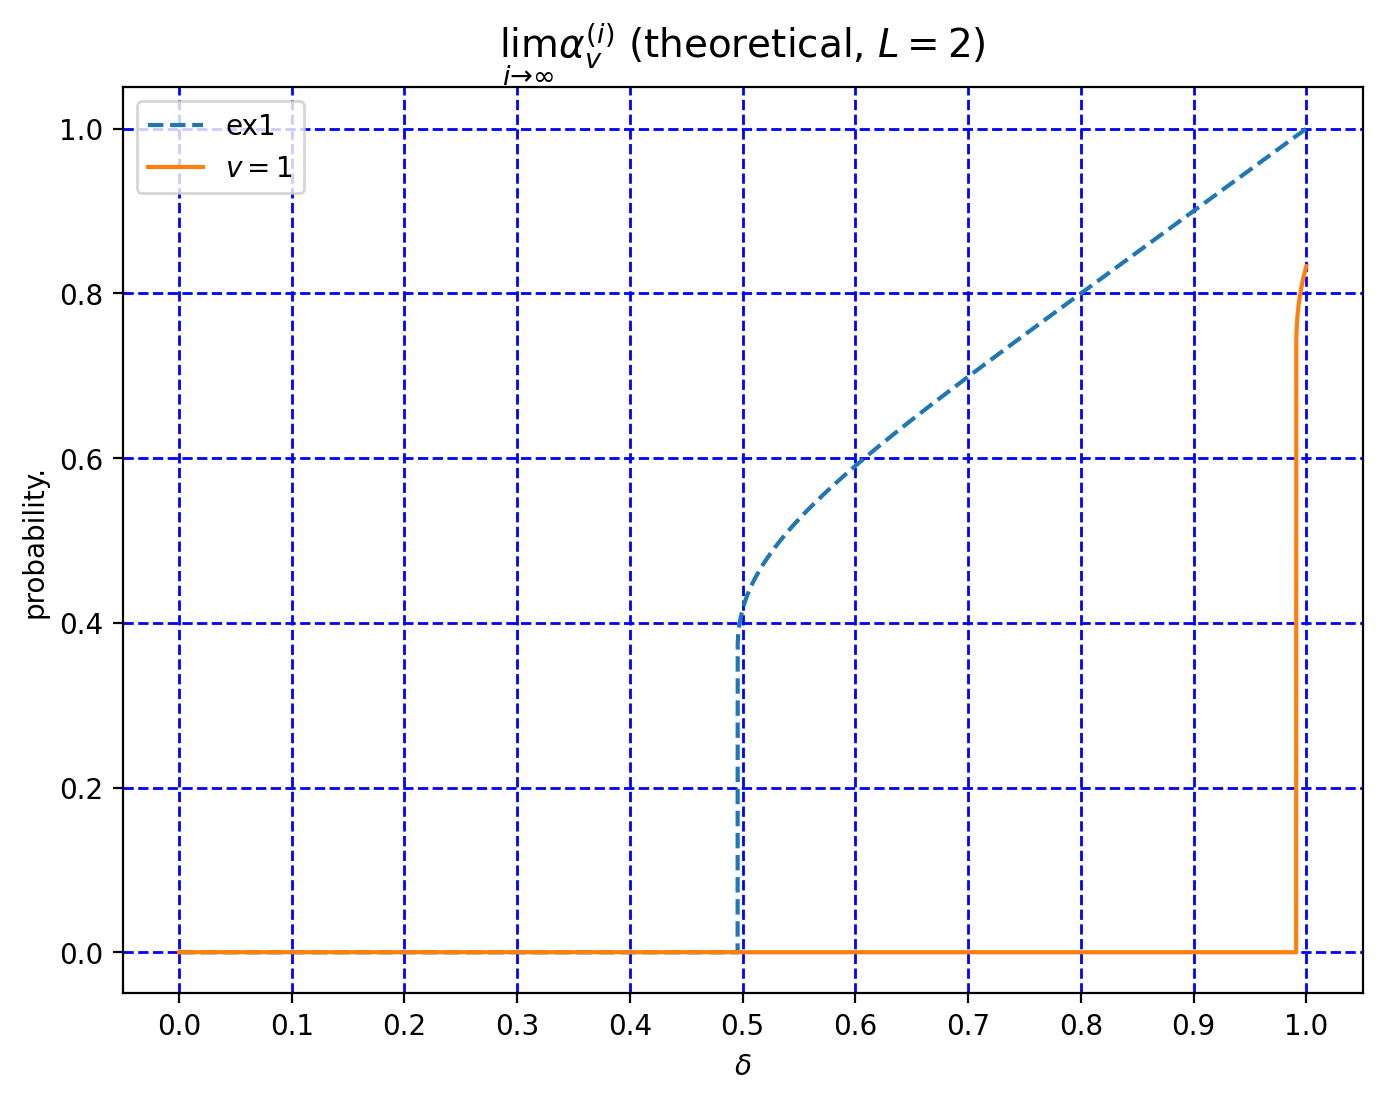

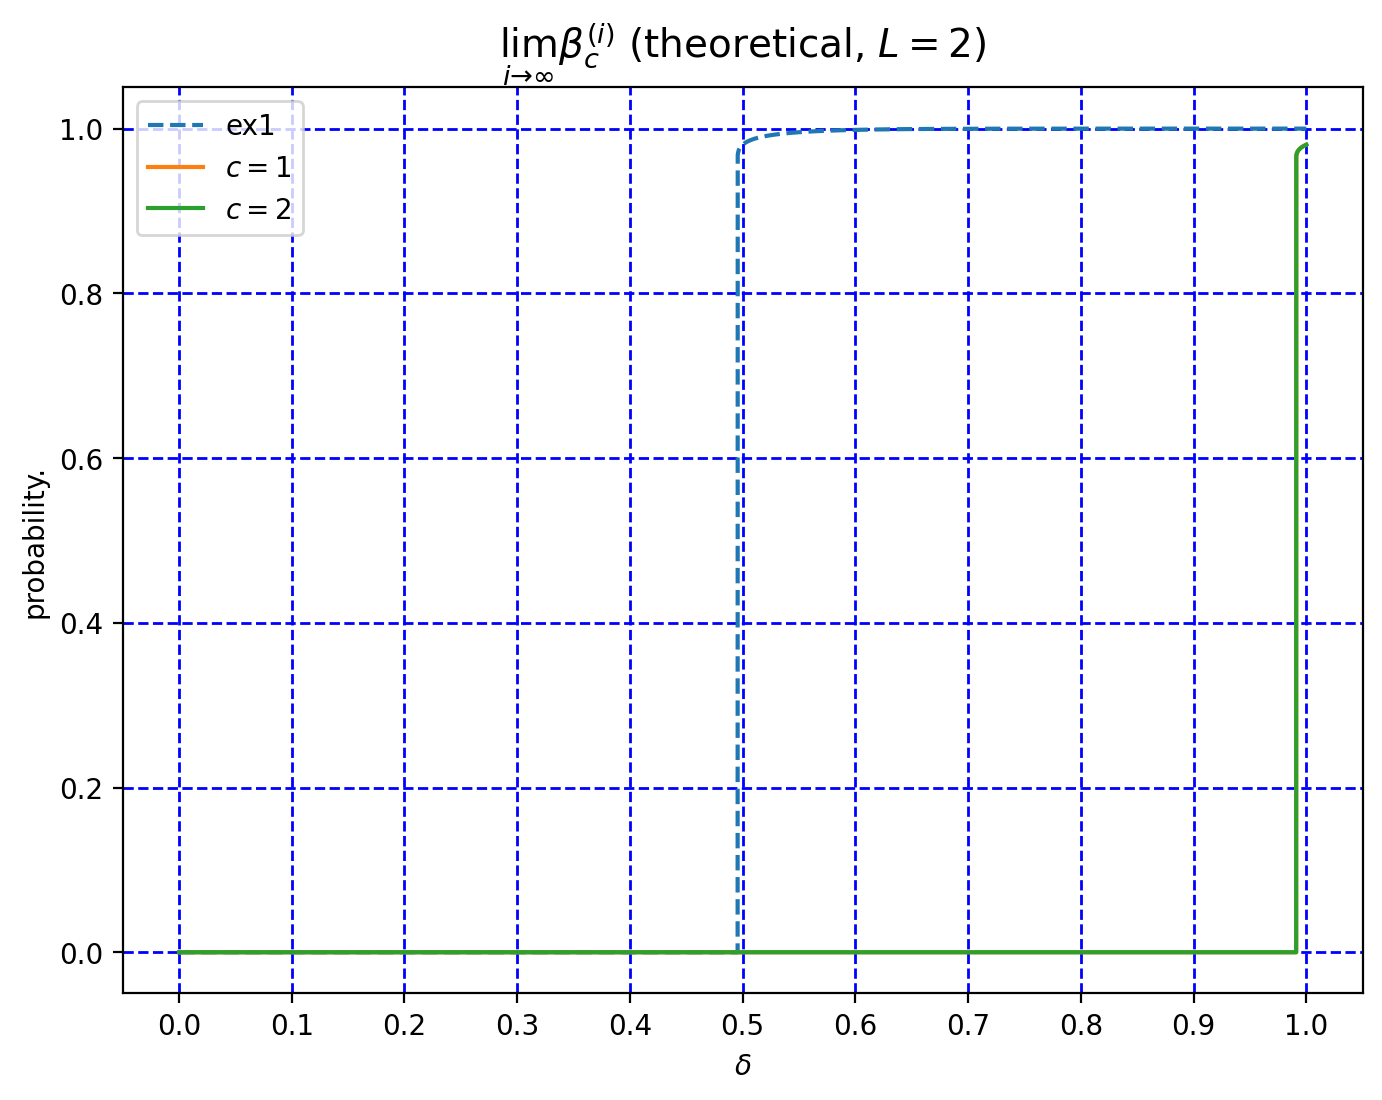

In [36]:
metrics = [alpha_lines_sho, beta_lines_sho]
metrics_str = ['av_limit', 'bc_limit']
metrics_LaTeX = [r'$\lim_{i\to\infty}\alpha_v^{(i)}$',
                 r'$\lim_{i\to\infty}\beta_c^{(i)}$']

for m, m_str, m_latex in zip(metrics, metrics_str, metrics_LaTeX):
    fig = plt.figure(figsize=(8,6), dpi=200)

    plt.xticks(deltas_tick) # 設定刻度
    plt.grid(color = 'blue', linestyle = '--', linewidth = 1) # 設定網格
    plt.title(m_latex + ' (theoretical, ' + r'$L=$' + str(L) + ')', fontsize = 14) # 標題
    plt.xlabel(r'$\delta$') # x軸標題
    plt.ylabel("probability.") # y軸標題

    colormap = plt.cm.gist_ncar # 顏色輪流出現
    
    lines = []
    
    if (m_str=='av_limit'):
        original_line = plt.plot(deltas, alpha_lines_sho_con, '--')
        for data, l in zip(m, alpha_range):
            line = plt.plot(deltas, data, '-')
            lines.append(r'$v=$' + str(l+1))
        lines.insert(0, 'ex1')
        plt.legend(lines)
    else:
        original_line = plt.plot(deltas, beta_lines_sho_con, '--')
        for data, l in zip(m, beta_range):
            line = plt.plot(deltas, data, '-')
            lines.append(r'$c=$' + str(l+1))
        lines.insert(0, 'ex1')
        plt.legend(lines)
    
    plt.savefig(sho_dir + m_str + '_L=' + str(L) + '_eta=' + str(eta) + '_sho_theoretical.png')
    plt.show()

### (4) Richardson's generating function

In [37]:
if (L != 2):
    col_list = ["delta", "alpha", "beta"]
    df = pd.read_csv(rich_dir + 'conventional' + '.csv', usecols=col_list)
    alpha_lines_rich_con = df["alpha"]
    beta_lines_rich_con = df["beta"]

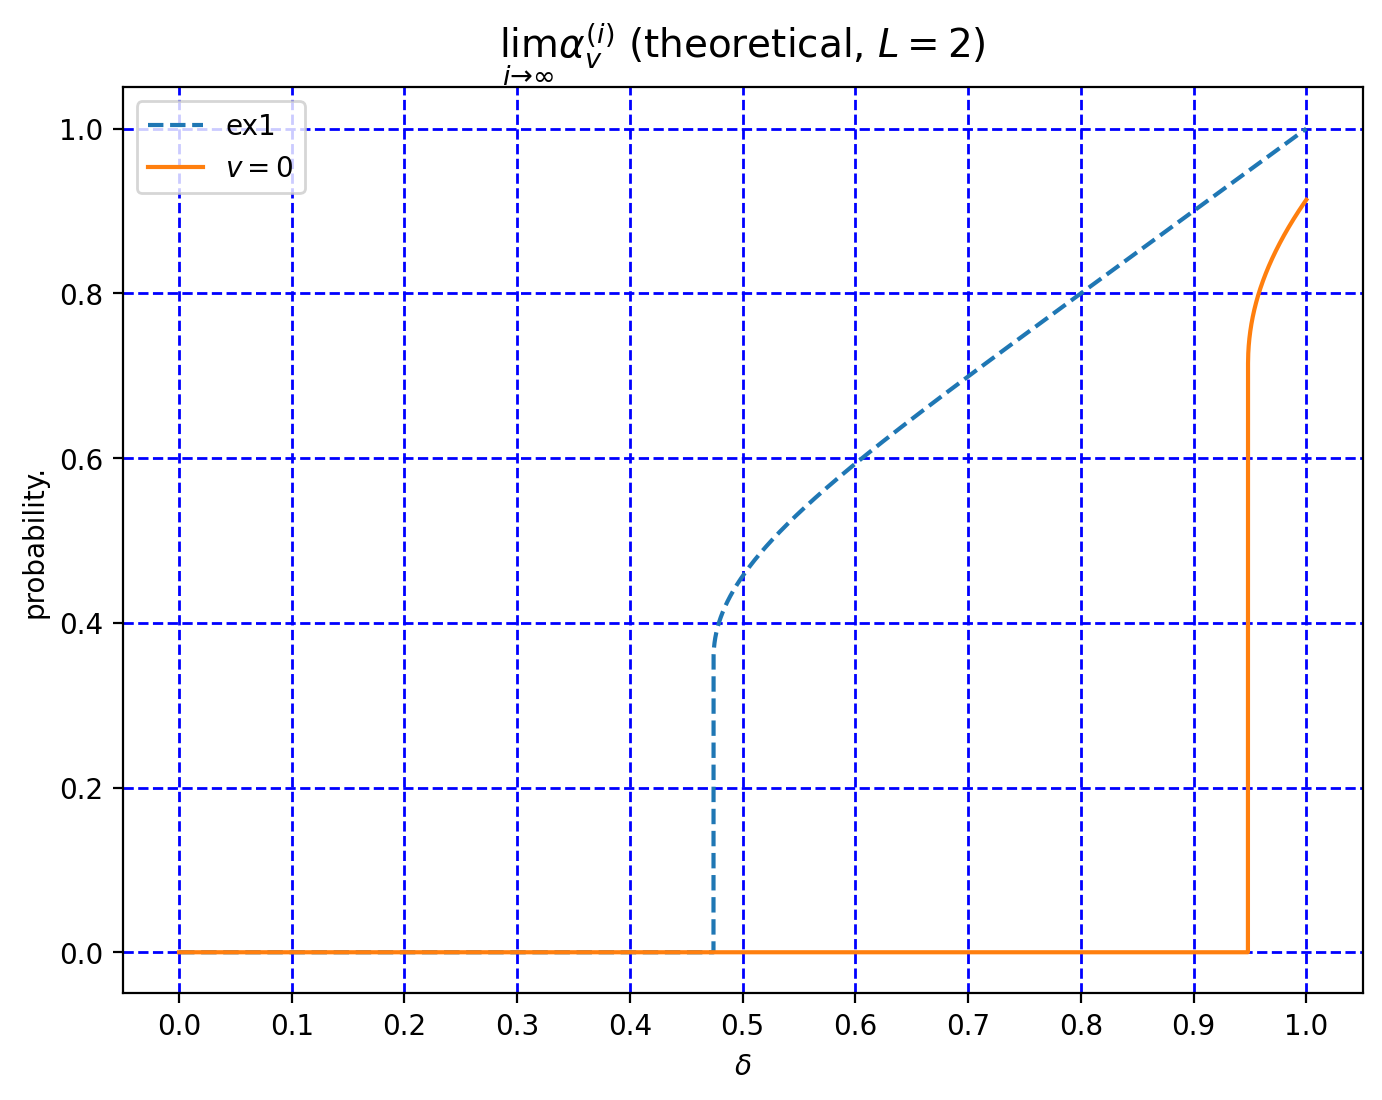

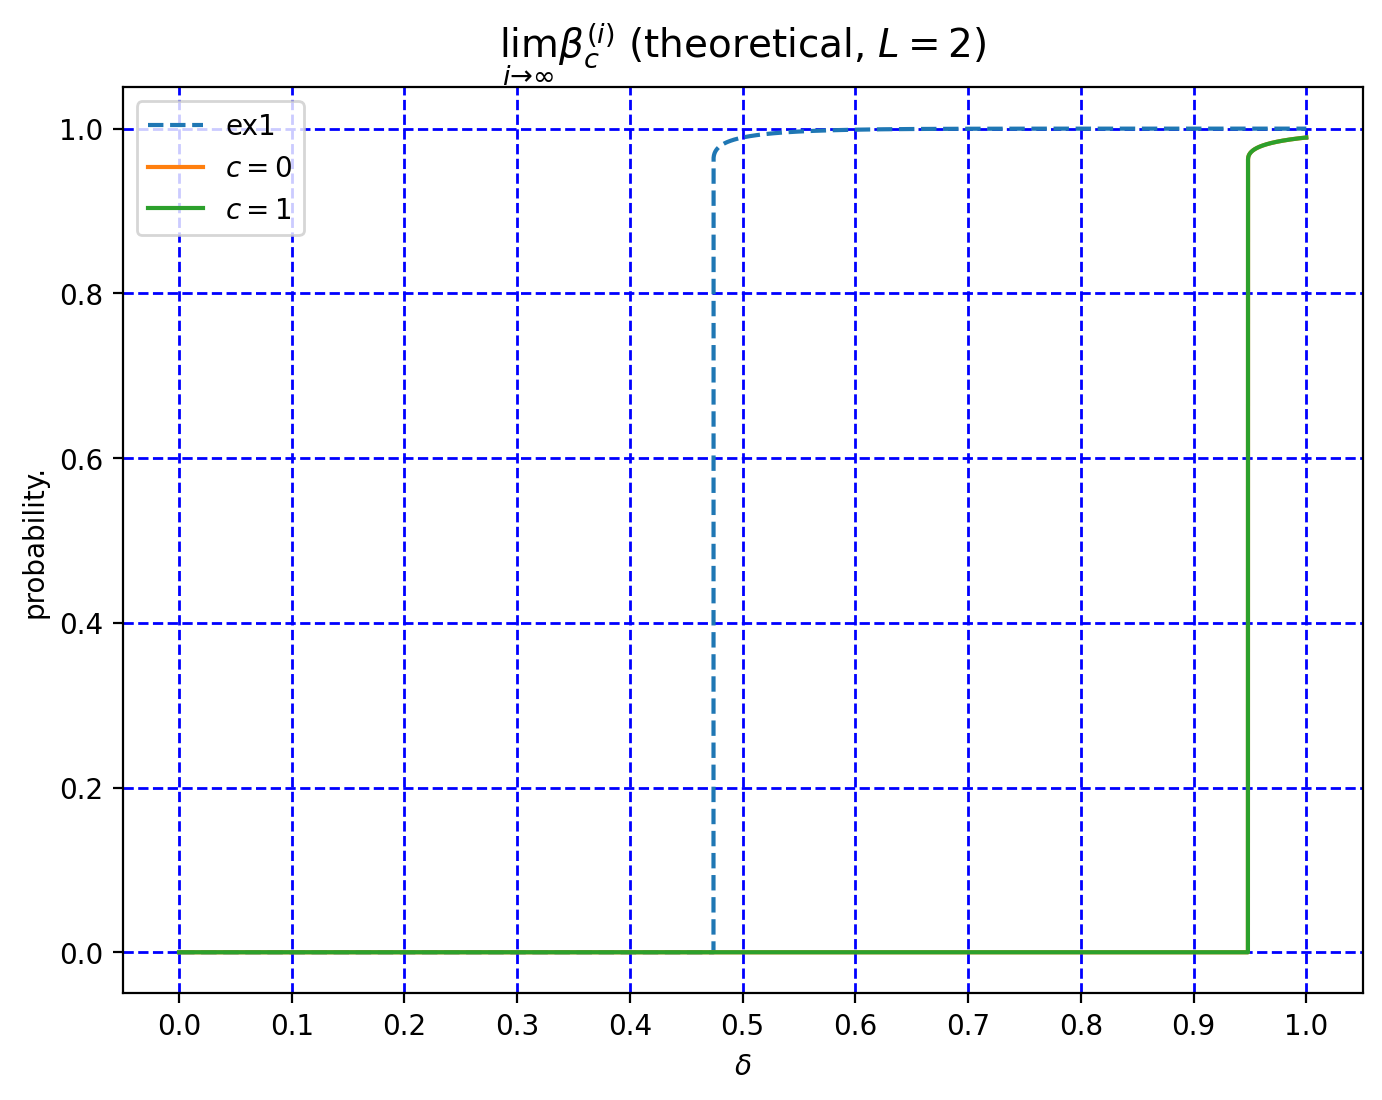

In [38]:
metrics = [alpha_lines_rich, beta_lines_rich]
metrics_str = ['av_limit', 'bc_limit']
metrics_LaTeX = [r'$\lim_{i\to\infty}\alpha_v^{(i)}$',
                 r'$\lim_{i\to\infty}\beta_c^{(i)}$']

for m, m_str, m_latex in zip(metrics, metrics_str, metrics_LaTeX):
    fig = plt.figure(figsize=(8,6), dpi=200)

    plt.xticks(deltas_tick) # 設定刻度
    plt.grid(color = 'blue', linestyle = '--', linewidth = 1) # 設定網格
    plt.title(m_latex + ' (theoretical, ' + r'$L=$' + str(L) + ')', fontsize = 14) # 標題
    plt.xlabel(r'$\delta$') # x軸標題
    plt.ylabel("probability.") # y軸標題

    colormap = plt.cm.gist_ncar # 顏色輪流出現
    
    lines = []
    
    if (m_str=='av_limit'):
        original_line = plt.plot(deltas, alpha_lines_rich_con, '--')
        for data, l in zip(m, alpha_range):
            line = plt.plot(deltas, data, '-')
            lines.append(r'$v=$' + str(l))
        lines.insert(0, 'ex1')
        plt.legend(lines)
    else:
        original_line = plt.plot(deltas, beta_lines_rich_con, '--')
        for data, l in zip(m, beta_range):
            line = plt.plot(deltas, data, '-')
            lines.append(r'$c=$' + str(l))
        lines.insert(0, 'ex1')
        plt.legend(lines)
    
    plt.savefig(rich_dir + m_str + '_L=' + str(L) + '_eta=' + str(eta) + '_rich_theoretical.png')
    plt.show()

## 5. Percolation Threshold

In [39]:
def find_threshold(lines): # 實驗組
    _list = []
    for l in lines:
        j = next((i for i, x in enumerate(l) if (x>1e-6)), None)
        _list.append(np.round(deltas[j], 5))
    return _list

def find_threshold_conventional(con_line): # 對照組
    j = next((i for i, x in enumerate(con_line) if (x>1e-6)), None)
    return np.round(deltas[j], 5)

In [40]:
th_list = find_threshold(alpha_lines)
th_list_irr = find_threshold(alpha_lines_irr)
th_list_sho = find_threshold(alpha_lines_sho)
th_list_rich = find_threshold(alpha_lines_rich)
th_con = find_threshold_conventional(alpha_lines_con)
th_irr_con = find_threshold_conventional(alpha_lines_irr_con)
th_sho_con = find_threshold_conventional(alpha_lines_sho_con)
th_rich_con = find_threshold_conventional(alpha_lines_rich_con)

In [41]:
with open(plot_dir + './threshold_reg_' + str(eta) + '.csv', 'a', newline = '') as csvFile:
    csvWriter = csv.writer(csvFile, delimiter = ',')
    if (L==2):
        csvWriter.writerow(['Regular (conventional)', th_con])
    csvWriter.writerow([L, min(th_list), max(th_list)])

In [42]:
with open(plot_dir + './threshold_irr_' + str(eta) + '.csv', 'a', newline = '') as csvFile:
    csvWriter = csv.writer(csvFile, delimiter = ',')
    if (L==2):
        csvWriter.writerow(['Irregular (conventional)', th_irr_con])
    csvWriter.writerow([L, min(th_list_irr), max(th_list_irr)])

In [43]:
with open(plot_dir + './threshold_sho_' + str(eta) + '.csv', 'a', newline = '') as csvFile:
    csvWriter = csv.writer(csvFile, delimiter = ',')
    if (L==2):
        csvWriter.writerow(['Shokrollahi (conventional)', th_sho_con])
    csvWriter.writerow([L, min(th_list_sho), max(th_list_sho)])

In [44]:
with open(plot_dir + './threshold_rich_' + str(eta) + '.csv', 'a', newline = '') as csvFile:
    csvWriter = csv.writer(csvFile, delimiter = ',')
    if (L==2):
        csvWriter.writerow(['Richardson (conventional)', th_rich_con])
    csvWriter.writerow([L, min(th_list_rich), max(th_list_rich)])